In [12]:
import pandas as pd
import sklearn
import numpy as np
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('/home/tteofili/Downloads/SBAnational.csv')
df.head()

/home/tteofili/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [7]:
bad_columns = ['LoanNr_ChkDgt', 'NAICS', 'ApprovalDate', 'DisbursementDate', 'Name', 'FranchiseCode']
target = 'MIS_Status'
categorical = ['City', 'State', 'Zip', 'Bank', 'BankState', 'NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc']
ordinal = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob']
money_columns = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
date_col = ['ChgOffDate']

In [8]:
# drop bad columns
df = df.dropna()
df = df.drop(columns=bad_columns)

In [9]:
# convert date to ordinal days
import datetime as dt
for c in date_col:
    df[c] = pd.to_datetime(df[c]).map(dt.datetime.toordinal)

In [13]:
# encode labels
le = preprocessing.LabelEncoder()
df[target] = le.fit_transform(df[target].astype(str))
class_names = le.classes_
print(class_names)

['CHGOFF' 'P I F']


In [14]:
# process ordinal features
for col in ordinal:
    df[col] = pd.to_numeric(df['ApprovalFY'].replace('1976A','1976', regex=False).replace('\d+\-\w+\-\d+|,','', regex=True))
    df[col] = df[col].astype('int32')
    

In [15]:
# process money columns
for c in money_columns:
    df[c] = df[c].replace('\$|,','', regex=True).replace('\(','-', regex=True).replace('\)','', regex=True)
    df[c] = pd.to_numeric(df[c])

In [16]:
# process categorical features
cat_idxs = [df.columns.get_loc(c) for c in categorical if c in df]
print(cat_idxs)
categorical_names = {}
for c in categorical:
    le = preprocessing.LabelEncoder()
    df[c] = le.fit_transform(df[c])
    categorical_names[c] = le.classes_

[0, 1, 2, 3, 4, 8, 11, 12, 13]


In [17]:
Y = df[target]
X = df.drop(columns=[target])

# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

[0.10455401 0.05624408 0.13117648 0.0511394  0.03643762 0.01973482
 0.01890612 0.02020768 0.01551645 0.0179864  0.02015033 0.01142808
 0.01612413 0.00225771 0.12444214 0.07380306 0.         0.1745929
 0.04615863 0.05913995]


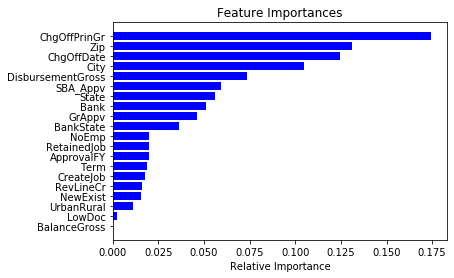

0.9709090909090909

In [18]:
rf = RandomForestClassifier(max_depth=16, random_state=0, n_estimators=10)
rf.fit(X_train, Y_train)  
print(rf.feature_importances_)
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
sklearn.metrics.accuracy_score(Y_test, rf.predict(X_test))


Counterfactual loss function = $L(x,x^\prime,y^\prime,\lambda)=\lambda\cdot(\hat{f}(x^\prime)-y^\prime)^2+d(x,x^\prime)$

In [214]:
x = X_train.values[0].reshape(-1,20)
y = rf.predict(x)

In [269]:
from scipy.spatial import distance
def d(a,b):
    return distance.cityblock(a, b)

In [272]:
def cf_loss(xp, l, x, y):
    xp = xp.reshape(-1,20)
    y_c = rf.predict(xp)
    diff = y_c-abs(1-y)
    distance = d(xp, x)
    loss = l * (diff)**2 + distance
    return loss[0]

In [ ]:
import random
l = 0.8
num_f=X_train.shape[1]

b = []
for c in range(num_f):
    b.append((X_train.values[:,c].min(), X_train.values[:,c].max())) 

i = 0
x_sample = X_train.values[random.randint(0, len(X_train.values)-1)]
while abs(rf.predict(x_sample.reshape(-1,num_f)) - y) < 0.01:
    #print(x_sample)
    cf_min = minimize(cf_loss, x_sample, method='SLSQP', args=(l, x, y), bounds=b)
    x_sample = cf_min.x
    cur_loss = cf_loss(x_sample,l,x,y)
    l += 1e-6
    i += 1
    if i % 100 == 0:
        print(str(i)+'-th iteration loss: '+str(cur_loss))
    

print("original input:"+x)
print("counterf input:"+x_sample)
print("counterf output:"+rf.predict(x_sample.reshape(-1,num_f)))

In [256]:
def cf_loss1(idx, l, X, x, y):
    try:
        idx = idx[0]
    except:
        pass
    idx = int(idx)
    xp = X[idx].reshape(-1,20)
    y_c = rf.predict(xp)
    diff = y_c-abs(1-y)
    distance = d(xp, x)
    loss = l * (diff)**2 + distance
    return loss[0]

In [ ]:
import random
l = 0.8
num_f=X_train.shape[1]

b = [(0, X_train.shape[0])]

i = 0
idx_sample = random.randint(0, num_f-1)
while abs(rf.predict(X_train.values[idx_sample].reshape(-1,num_f)) - y) < 0.01:
    cf_min = minimize(cf_loss1, idx_sample, method='SLSQP', args=(l, X_train.values, x, y), bounds=b)
    idx_sample = int(cf_min.x[0])
    cur_loss = cf_loss1(idx_sample,l,X_train.values,x,y)
    l += 1e-3
    i += 1
    if i % 100 == 0:
        print(str(i)+'-th iteration loss: '+str(cur_loss))
    

print("original input:"+x)
print("counterf input:"+x_sample)
print("counterf output:"+rf.predict(x_sample.reshape(-1,num_f)))